Entrer une devise:eth

        Date Trend      Close       MM20       MM50  DIFF MM20-50
 2021-05-14    UP  4079.8405  3323.7379  2603.2672      720.4707
 2021-05-15    UP  3647.8494  3390.0019  2642.2315      747.7704
 2021-05-16    UP  3586.4878  3442.5656  2679.6935      762.8721
 2021-05-17  DOWN  3282.5393  3473.2817  2711.6085      761.6732
 2021-05-18  DOWN  3378.8633  3504.7195  2742.8541      761.8654
 2021-05-19  DOWN  2443.6332  3488.9585  2754.8890      734.0695
 2021-05-20  DOWN  2775.3959  3488.9934  2771.9940      716.9994
 2021-05-21  DOWN  2435.7281  3463.4402  2781.3517      682.0885
 2021-05-22  DOWN  2298.4954  3430.7943  2784.6408      646.1535
 2021-05-23  DOWN  2099.9140  3364.2000  2786.4671      577.7329
 2021-05-24  DOWN  2650.6224  3334.6412  2797.9482      536.6930
 2021-05-25  DOWN  2707.4259  3293.6098  2809.9489      483.6609
 2021-05-26  DOWN  2888.9700  3263.4653  2825.4809      437.9844
 2021-05-27  DOWN  2744.3999  3226.5444  2841.1049      385.4395
 

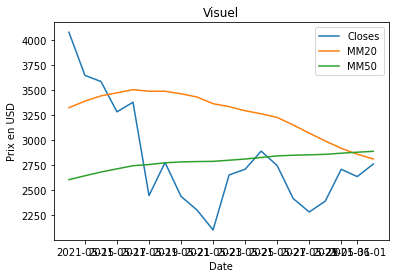

In [8]:
import requests
import pprint
import json
import time
import datetime
import statistics
import sys
import pandas as pd
import matplotlib.pyplot as plt

asset = input("Entrer une devise:")

ajd = datetime.date.today()
dates_list = [ajd - datetime.timedelta(days=i) for i in range(101)]
hier = dates_list[1]
ajd_moins_100 = dates_list[100]

restest = requests.get(f"https://data.messari.io/api/v1/assets/{asset}/metrics/price/time-series?after={ajd_moins_100}&interval=1d")

try:
	data = json.loads(restest.text)
except (ConnectionError, Timeout, TooManyRedirects) as e:
	print(e)

closes_data = [round(data["data"]["values"][i][4], 4) for i in range(len(data["data"]["values"]))]
closes = closes_data[::-1]

def mm_list(x):
	return [round(statistics.mean(closes[i:x+i]), 4) for i in range(x)]

mm_20 = mm_list(20)
mm_50 = mm_list(50)

diff_mm20 = [(closes[i] - mm_20[i]) for i in range(20)]

def get_trend(val):
	trend = "SAME"
	if val > 0:
		trend = "UP"
	elif val < 0:
		trend = "DOWN"
	return trend

trend_list = [get_trend(diff_mm20[i]) for i in range(20)]

ecart_mms = [mm_20[i]-mm_50[i] for i in range(20)]

db_final = pd.DataFrame(
	{"Date": dates_list[:20],
	"Trend": trend_list[:20],
	"Close": closes[:20],
	"MM20": mm_20[:20],
	"MM50": mm_50[:20], 
	"DIFF MM20-50": ecart_mms[:20]
	})

reco = f"Pas de changement de tendance sur dernier close : {trend_list[1]}"
if trend_list[1] == "UP" and trend_list[2] == "DOWN":
	reco = "Signal d'achat. Changement de tendance de DOWN vers UP. Observer le marché pour tendance haussière éventuelle"
	confirmation_mms = "Confirmation éventuelle pour achat : MM20 supérieur à MM50" if ecart_mms[1] >= 0 else "Attention, MM20 inférieur à MM50"
if trend_list[1] == "DOWN" and trend_list[2] == "UP":
	reco = "Signal de vente. Changement de tendance de UP vers DOWN. Observer le marché pour tendance baissière éventuelle"

evo = round(((closes[0]-closes[1])/closes[1])*100, 2)

print("\n", db_final.sort_values(["Date"], ascending=[True])[0:19].to_string(index=False))
#print("\n"f"CLOSE AU {hier}:", closes[1])
print("\nCURRENT:", closes[0], f"({get_trend(evo)} DEPUIS HIER : {evo}%)", "\n")
print(reco, "\n")
try:
	print(confirmation_mms, "\n")
except:
	pass

plt.plot(db_final["Date"], db_final["Close"], label="Closes")
plt.plot(db_final["Date"], db_final["MM20"], label="MM20")
plt.plot(db_final["Date"], db_final["MM50"], label="MM50")
plt.xlabel("Date")
plt.ylabel("Prix en USD")
plt.title("Visuel")
plt.legend()
plt.show()